# Classification Models

## Importing libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

## Load train/test data

In [2]:
with open("processed_data/X_train_clf.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("processed_data/X_test_clf.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("processed_data/y_train_clf.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("processed_data/y_test_clf.pkl", "rb") as f:
    y_test = pickle.load(f)

## Handle Imbalance data

In [3]:
# Handle imbalance
smote = SMOTE(sampling_strategy=0.7, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# verify class balance
print(y_train_res.value_counts(normalize=True) * 100)

Churn
0.0    58.834281
1.0    41.165719
Name: proportion, dtype: float64


## Feature Selection

#### Chi-Squared Test for all categorical features

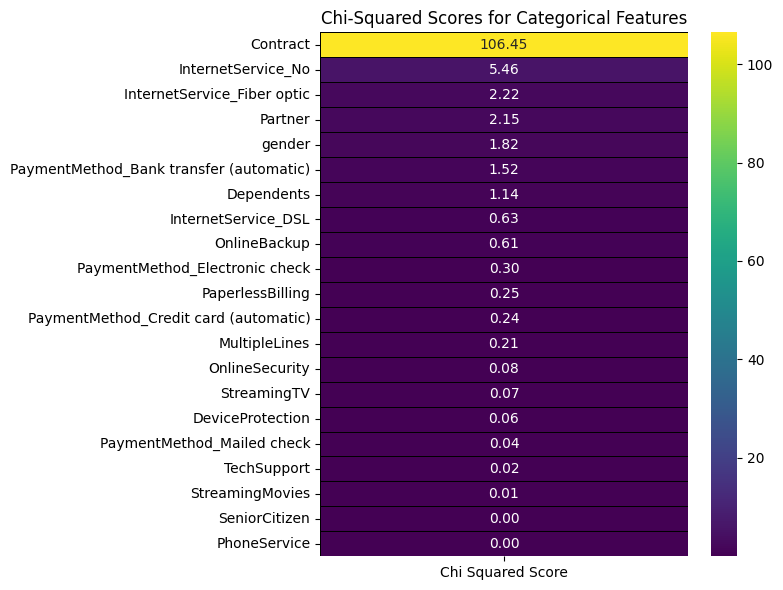

In [4]:
categorical_features = [
    'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No',
    'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
    'Contract', 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen'
]


features = X_train_res.loc[:, categorical_features]
target = pd.DataFrame(y_train_res, columns=['Churn'])

# Apply Chi-Squared test
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(features, target)

# DataFrame with Chi-Squared scores
featureScores = pd.DataFrame(data=fit.scores_, index=features.columns, columns=['Chi Squared Score'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    featureScores.sort_values(by='Chi Squared Score', ascending=False),
    annot=True, cmap='viridis', linewidths=0.4, linecolor='black', fmt='.2f'
)
plt.title('Chi-Squared Scores for Categorical Features')
plt.tight_layout()
plt.show()

#### ANOVA-based feature selection on the numerical features.

d:\Acedamics\Sculptsoft\SSPL_Internship_Daily_Log_ Local\Practical_Assessment\Customer_analytics_for_telecom_provider\.venv\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


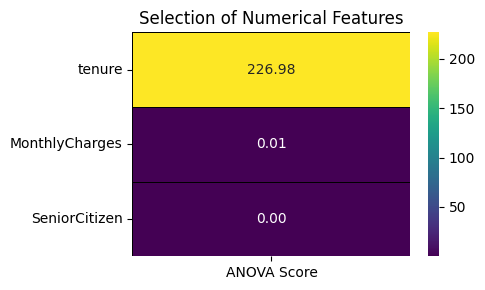

In [5]:
numerical_features = ['tenure', 'MonthlyCharges', 'SeniorCitizen']

# Select numerical features from X_train_res
features = X_train_res.loc[:, numerical_features]
target = pd.DataFrame(y_train_res, columns=['Churn'])

# Apply ANOVA F-test
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)

# Create a DataFrame with ANOVA scores
featureScores = pd.DataFrame(data=fit.scores_, index=features.columns, columns=['ANOVA Score'])

# Plot heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(
    featureScores.sort_values(by='ANOVA Score', ascending=False),
    annot=True, cmap='viridis', linewidths=0.4, linecolor='black', fmt='.2f'
)
plt.title('Selection of Numerical Features')
plt.tight_layout()
plt.show()

#### Final Selected Features

In [6]:
# selected features based on Chi-Squared heatmap
selected_features = [
    'Contract', 'InternetService_No', 'gender', 'InternetService_Fiber optic', 'PaymentMethod_Bank transfer (automatic)', 'Partner', 'OnlineBackup', 'PaymentMethod_Mailed check', 'tenure']

# Filter the resampled training and test data
X_train_selected = X_train_res.loc[:, selected_features]
X_test_selected = X_test.loc[:, selected_features]

print("Final selected features:", selected_features)

Final selected features: ['Contract', 'InternetService_No', 'gender', 'InternetService_Fiber optic', 'PaymentMethod_Bank transfer (automatic)', 'Partner', 'OnlineBackup', 'PaymentMethod_Mailed check', 'tenure']


## Scaling using StandardScaler

In [7]:
# Features to scale
col_to_scale = ['tenure']

scaler_cls = StandardScaler()
# Fit-transform on train, transform on test
X_train_selected[col_to_scale] = scaler_cls.fit_transform(X_train_selected[col_to_scale])
X_test_selected[col_to_scale] = scaler_cls.transform(X_test_selected[col_to_scale])

## Model Training

Evaluation metrices

In [8]:
def model_evaluation(classifier, x_test, y_test):
    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    cm = confusion_matrix(y_test, classifier.predict(x_test))
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value / np.sum(cm)) for value in cm.flatten()]
    labels = [f'{name}\n{count}\n{perc}' for name, count, perc in zip(names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='')

    # Classification Report
    print(classification_report(y_test, classifier.predict(x_test)))

    # ROC Curve and AUC Score
    y_prob = classifier.predict_proba(x_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    print(f"ROC AUC Score: {auc_score:.2f}")

### 1. Logistic Regression

In [9]:
# train logistic regression model
ls = LogisticRegression()
ls.fit(X_train_selected, y_train_res)

LogisticRegression()

              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       725
         1.0       0.43      0.39      0.41       262

    accuracy                           0.70       987
   macro avg       0.61      0.60      0.61       987
weighted avg       0.69      0.70      0.70       987



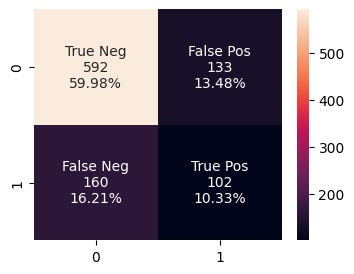

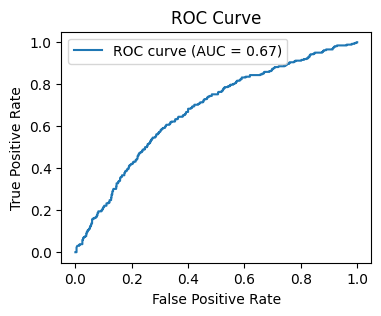

ROC AUC Score: 0.67


In [10]:
# evaluate
y_pred = ls.predict(X_test_selected)
ls_results = model_evaluation(ls, X_test_selected, y_test)

### 2. Random Forest

In [11]:
rfc = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=42, min_samples_split=2, n_jobs=-1)
rfc.fit(X_train_selected, y_train_res)

RandomForestClassifier(max_depth=8, n_jobs=-1, random_state=42)

              precision    recall  f1-score   support

         0.0       0.75      0.94      0.84       725
         1.0       0.48      0.15      0.23       262

    accuracy                           0.73       987
   macro avg       0.62      0.55      0.53       987
weighted avg       0.68      0.73      0.68       987



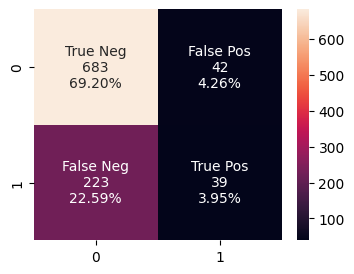

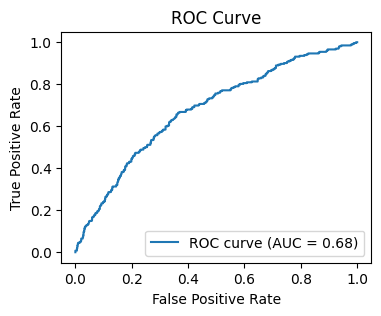

ROC AUC Score: 0.68


In [12]:
# evaluate
y_pred = rfc.predict(X_test_selected)
rfc_results = model_evaluation(rfc, X_test_selected, y_test)

### 3. Support Vector Classifier (SVC)

In [13]:
# SVM training on Sampled Data:
svm = SVC(kernel='linear', class_weight='balanced', gamma='scale',random_state=42, C=1,verbose=True, degree=3, probability=True)
svm.fit(X_train_selected, y_train_res)

[LibSVM]

SVC(C=1, class_weight='balanced', kernel='linear', probability=True,
    random_state=42, verbose=True)

              precision    recall  f1-score   support

         0.0       0.83      0.63      0.72       725
         1.0       0.39      0.64      0.48       262

    accuracy                           0.63       987
   macro avg       0.61      0.64      0.60       987
weighted avg       0.71      0.63      0.65       987



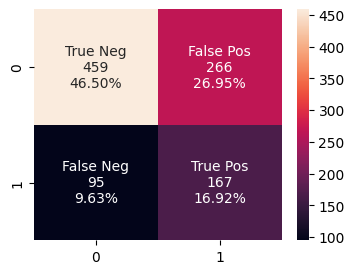

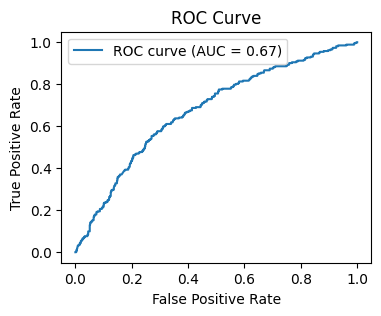

ROC AUC Score: 0.67


In [14]:
y_pred = svm.predict(X_test_selected)
svm_results = model_evaluation(svm, X_test_selected, y_test)